In [3]:
from scipy.signal import butter, filtfilt, iirnotch, hilbert, lfilter
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd
import pywt

In [4]:
file_path = 'signal_2_data.csv'

# Read the CSV file
df = pd.read_csv(file_path)
df = df[(df['Time (s)'] >= 0) & (df['Time (s)'] <= 40)]
print(df)

# Metadata
fs = 3000  # Sampling frequency in Hz

         Time (s)  EMG Signal
0        0.000000    0.008547
1        0.000333    0.010989
2        0.000667    0.018315
3        0.001000    0.003663
4        0.001333    0.008547
...           ...         ...
119996  39.998667    0.001221
119997  39.999000   -0.003663
119998  39.999333   -0.006105
119999  39.999667   -0.003663
120000  40.000000   -0.008547

[120001 rows x 2 columns]


In [5]:
# Parameters for powerline interference
powerline_freq = 50  # Frequency of powerline interference (Hz)
amplitude = 0.1  # Base amplitude of the interference
variable_amplitude = amplitude * (1 + 0.5 * np.sin(2 * np.pi * 0.1 * df['Time (s)']))  # Variable amplitude
# print(np.mean(variable_amplitude))

# Generate powerline interference
interference = variable_amplitude * np.sin(2 * np.pi * powerline_freq * df['Time (s)'])

df['EMG Signal'] = df['EMG Signal'] + interference

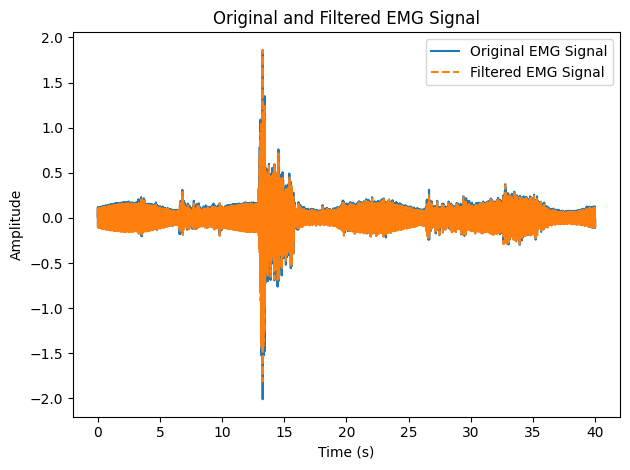

In [6]:
# Extract the signal
signal = df['EMG Signal']

# Design the bandpass filter
lowcut = 20.0
highcut = 500.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Apply the filter to the signal
filtered_signal = filtfilt(b, a, signal)

# Plot the original and filtered signals
fig, ax = plt.subplots()
ax.plot(df['Time (s)'], signal, label='Original EMG Signal')
ax.plot(df['Time (s)'], filtered_signal, label='Filtered EMG Signal', linestyle='--')
ax.set_title("Original and Filtered EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

signal = filtered_signal

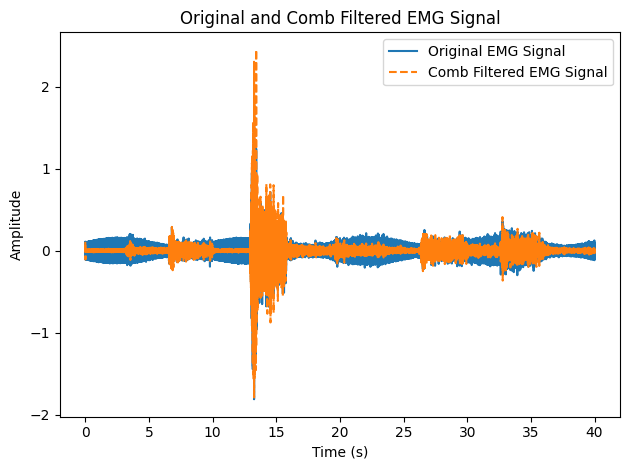

In [7]:
# Define the comb filter
def comb_filter(signal, delay, alpha):
    b = np.zeros(delay + 1)
    b[0] = 1
    b[-1] = -alpha
    a = [1]
    return lfilter(b, a, signal)

# Parameters for the comb filter
delay = int(fs / 50)  # Delay in samples (for 50 Hz)
alpha = 0.95  # Feedback coefficient

# Apply the comb filter to the signal
filtered_signal_FFC = comb_filter(signal, delay, alpha)

# Plot the original and filtered signals
fig, ax = plt.subplots()
ax.plot(df['Time (s)'], signal, label='Original EMG Signal')
ax.plot(df['Time (s)'], filtered_signal_FFC, label='Comb Filtered EMG Signal', linestyle='--')
ax.set_title("Original and Comb Filtered EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

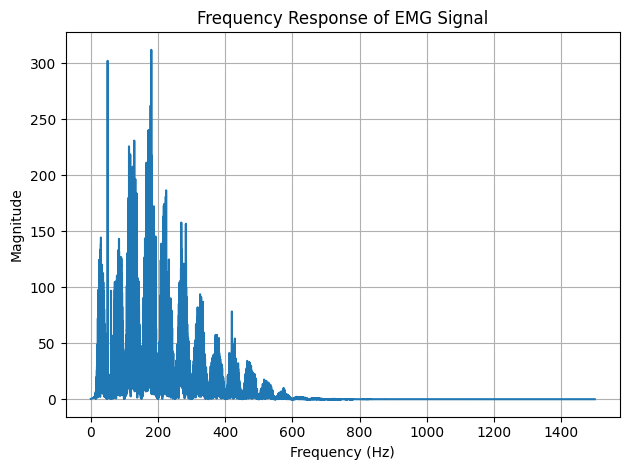

In [8]:
# Compute the FFT
n = len(filtered_signal_FFC)
fft_signal = np.fft.fft(filtered_signal_FFC)
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of EMG Signal")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()